# Task 2

## Imports

In [1]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
from typing import Union, Tuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from task1.retrieval_system import RetrievalSystem, SongInfo
from task1.similarity_measure import (
    cosine_similarity,
    dot_product,
    manhattan_distance,
    euclidean_distance,
    random_similarity,
)
from utils import read, embed_and_merge

# basic song information from task 1
df = read("information", 0)

## Load data

In [2]:
# add genre information for metric calculation
genres = read("genres", 0)
# convert genre to actual list via eval
genres["genre"] = genres["genre"].apply(eval).apply(set)
df = df.merge(genres, on="id", how="left")

In [3]:
for feature in ["mfcc_bow", "blf_spectral", "ivec256", "ivec1024", "musicnn"]:
    stats = read(feature, 0)
    df = embed_and_merge(df, stats, feature)

In [4]:
for text_feature in ["lyrics_bert", "lyrics_word2vec", "lyrics_tf-idf"]:
    stats = read(text_feature, 0)
    df = embed_and_merge(df, stats, text_feature.split("_")[1])

In [5]:
# data for task 2 does not include the item with id "03Oc9WeMEmyLLQbj" = row 5
df = df.drop(5)
df = df.reset_index()

## Instantiate retrieval systems

In [6]:
# create pd dataframe consisting of all retrieval systems, with metric and feature
rs = pd.DataFrame(
    [
        ["random", "random", RetrievalSystem(
            df=df,
            sim_metric=random_similarity,
        )],
        ["cosine", "tf-idf", RetrievalSystem(
            df=df,
            sim_metric=cosine_similarity,
            sim_feature="tf-idf",
        )],
        ["cosine", "bert", RetrievalSystem(
            df=df,
            sim_metric=cosine_similarity,
            sim_feature="bert",
        )],
        ["dot", "word2vec", RetrievalSystem(
            df=df,
            sim_metric=dot_product,
            sim_feature="word2vec",
        )],
        ["cosine", "mfcc_bow", RetrievalSystem(
            df=df,
            sim_metric=cosine_similarity,
            sim_feature="mfcc_bow",
        )],
        ["cosine", "blf_spectral", RetrievalSystem(
            df=df,
            sim_metric=cosine_similarity,
            sim_feature="blf_spectral",
        )],
        ["cosine", "ivec256", RetrievalSystem(
            df=df,
            sim_metric=cosine_similarity,
            sim_feature="ivec256",
        )],
        ["cosine", "musicnn", RetrievalSystem(
            df=df,
            sim_metric=cosine_similarity,
            sim_feature="musicnn",
        )],
    ],
    columns=["metric", "feature", "rs_object"],
)
rs

,metric,feature,rs_object
0,random,random,<task1.retrieval_system.RetrievalSystem object...
1,cosine,tf-idf,<task1.retrieval_system.RetrievalSystem object...
2,cosine,bert,<task1.retrieval_system.RetrievalSystem object...
3,dot,word2vec,<task1.retrieval_system.RetrievalSystem object...
4,cosine,mfcc_bow,<task1.retrieval_system.RetrievalSystem object...
5,cosine,blf_spectral,<task1.retrieval_system.RetrievalSystem object...
6,cosine,ivec256,<task1.retrieval_system.RetrievalSystem object...
7,cosine,musicnn,<task1.retrieval_system.RetrievalSystem object...


## Evaluation

In [7]:
from task2.pipeline import Pipeline

evaluate = Pipeline(rs, genres)

Creating genre overlap matrix:   0%|          | 0/10094 [00:00<?, ?it/s]

Creating result lists for every rs (max_k=100):   0%|          | 0/8 [00:00<?, ?it/s]

loaded results for system.metric='random', system.feature='random' from "results/random_random_results_100.npy"
loaded results for system.metric='cosine', system.feature='tf-idf' from "results/cosine_tf-idf_results_100.npy"
loaded results for system.metric='cosine', system.feature='bert' from "results/cosine_bert_results_100.npy"
loaded results for system.metric='dot', system.feature='word2vec' from "results/dot_word2vec_results_100.npy"
loaded results for system.metric='cosine', system.feature='mfcc_bow' from "results/cosine_mfcc_bow_results_100.npy"
loaded results for system.metric='cosine', system.feature='blf_spectral' from "results/cosine_blf_spectral_results_100.npy"
loaded results for system.metric='cosine', system.feature='ivec256' from "results/cosine_ivec256_results_100.npy"
loaded results for system.metric='cosine', system.feature='musicnn' from "results/cosine_musicnn_results_100.npy"


In [8]:
evaluation = evaluate.run([
    (Pipeline.mean_precision_at_k, dict(k=10)),
    (Pipeline.mean_recall_at_k, dict(k=10)),
    (Pipeline.precision_and_recall_interval, dict(k_min=1, k_max=100, step_size=5)),
    (Pipeline.mean_ndcg_at_k, dict(k=10)),
    (Pipeline.genre_coverage_at_k, dict(k=10)),
])
evaluation.to_csv("task_2.csv", index=False)
evaluation

running pipeline:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating 'mean_precision_at_k' with {'k': 10}:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating 'mean_recall_at_k' with {'k': 10}:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating 'precision_and_recall_interval' with {'k_min': 1, 'k_max': 100, 'step_size': 5}:   0%|          | …

... for metric_name='random', feature_name='random':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='tf-idf':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='bert':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='dot', feature_name='word2vec':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='mfcc_bow':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='blf_spectral':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='ivec256':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='musicnn':   0%|          | 0/10094 [00:00<?, ?it/s]

Calculating 'mean_ndcg_at_k' with {'k': 10}:   0%|          | 0/8 [00:00<?, ?it/s]

... for metric_name='random', feature_name='random':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='tf-idf':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='bert':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='dot', feature_name='word2vec':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='mfcc_bow':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='blf_spectral':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='ivec256':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='musicnn':   0%|          | 0/10094 [00:00<?, ?it/s]

Calculating 'genre_coverage_at_k' with {'k': 10}:   0%|          | 0/8 [00:00<?, ?it/s]

,metric,feature,rs_object,mean_precision_at_k,mean_recall_at_k,precision_and_recall_interval,mean_ndcg_at_k,genre_coverage_at_k
0,random,random,<task1.retrieval_system.RetrievalSystem object...,0.442520,0.000976,recall precision k ...,0.131709,1.000000
1,cosine,tf-idf,<task1.retrieval_system.RetrievalSystem object...,0.510709,0.001340,recall precision k ...,0.163754,0.982014
2,cosine,bert,<task1.retrieval_system.RetrievalSystem object...,0.557192,0.001862,recall precision k ...,0.196265,0.956835
3,dot,word2vec,<task1.retrieval_system.RetrievalSystem object...,0.455934,0.000933,recall precision k ...,0.124160,0.480216
4,cosine,mfcc_bow,<task1.retrieval_system.RetrievalSystem object...,0.588518,0.001737,recall precision k ...,0.216050,0.981115
5,cosine,blf_spectral,<task1.retrieval_system.RetrievalSystem object...,0.589935,0.001800,recall precision k ...,0.218365,0.972122
6,cosine,ivec256,<task1.retrieval_system.RetrievalSystem object...,0.565564,0.001712,recall precision k ...,0.208839,0.999101
7,cosine,musicnn,<task1.retrieval_system.RetrievalSystem object...,0.623598,0.001937,recall precision k ...,0.231601,0.997302


### Precision Recall Curves

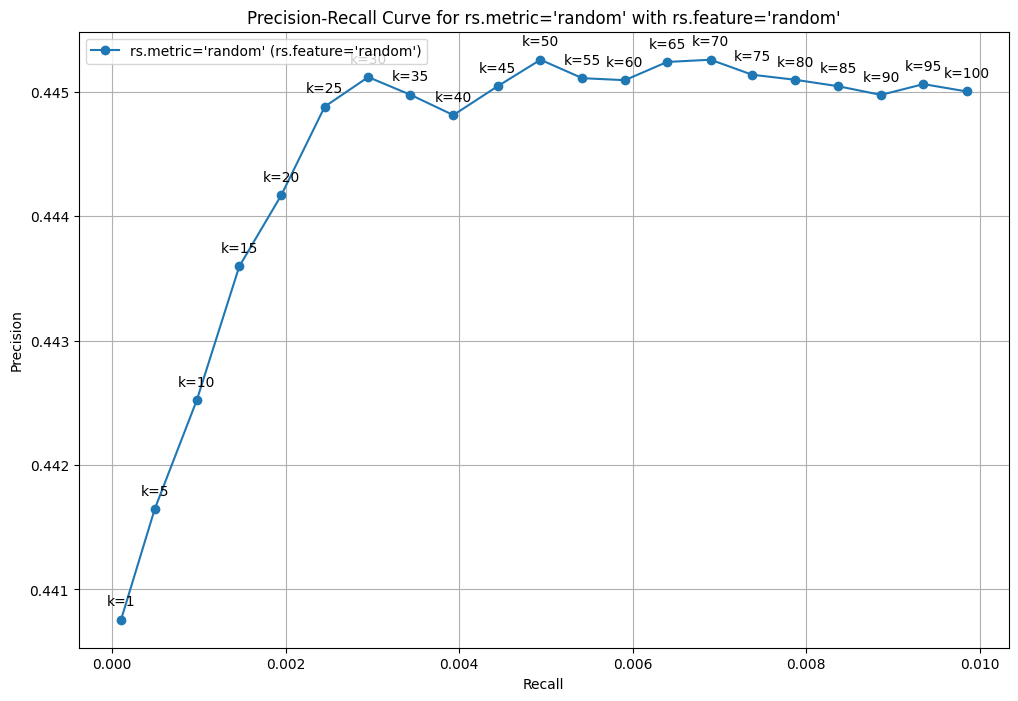

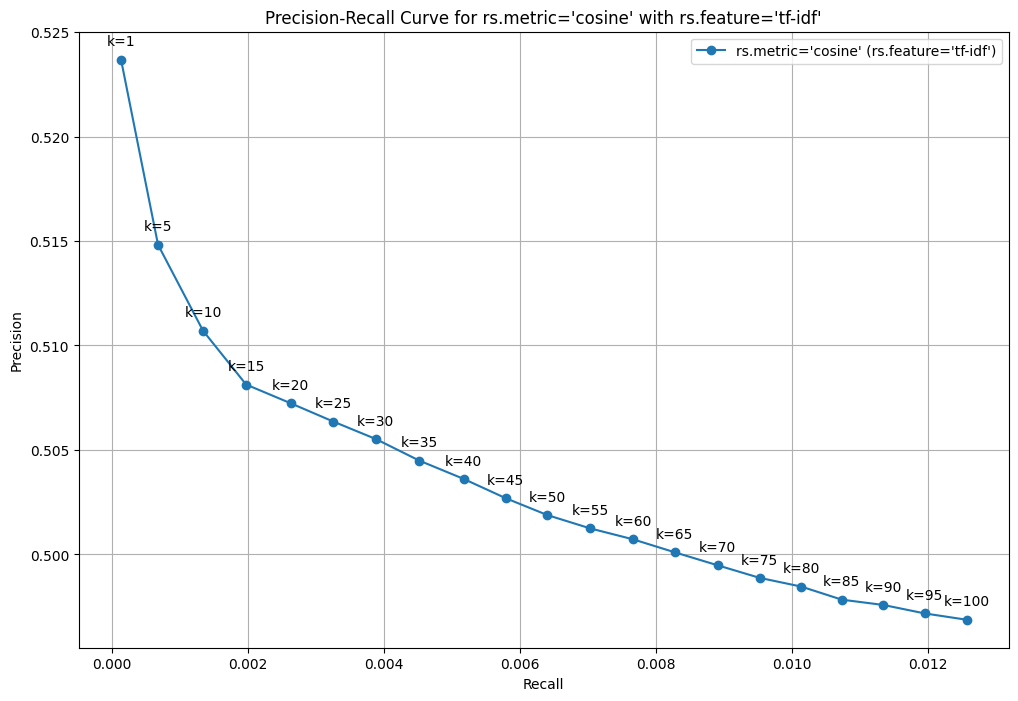

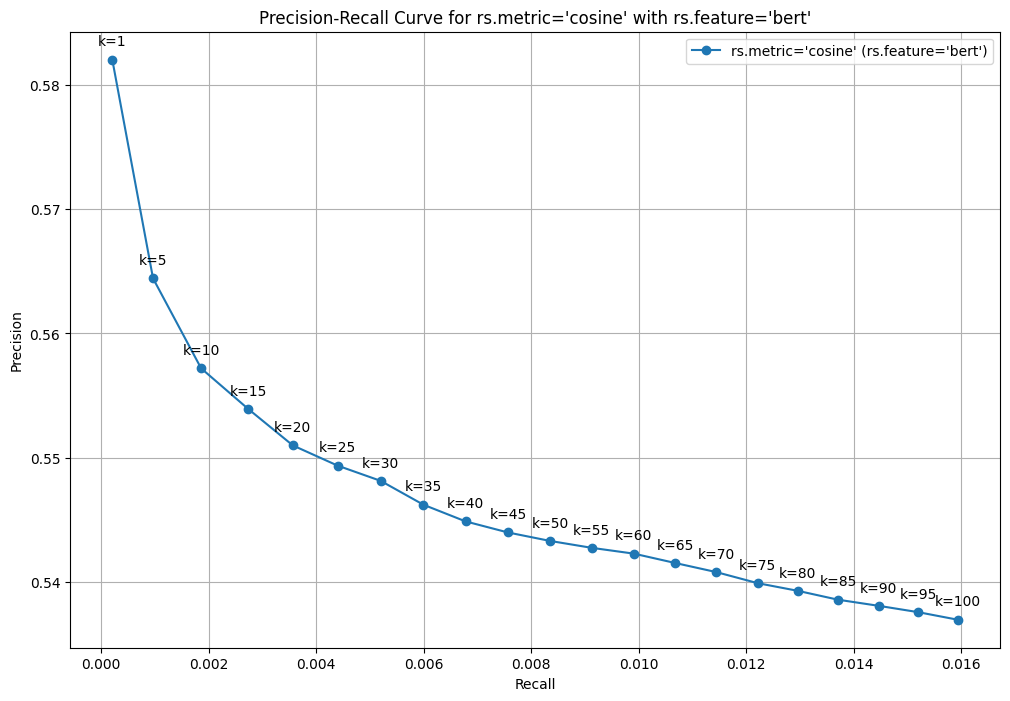

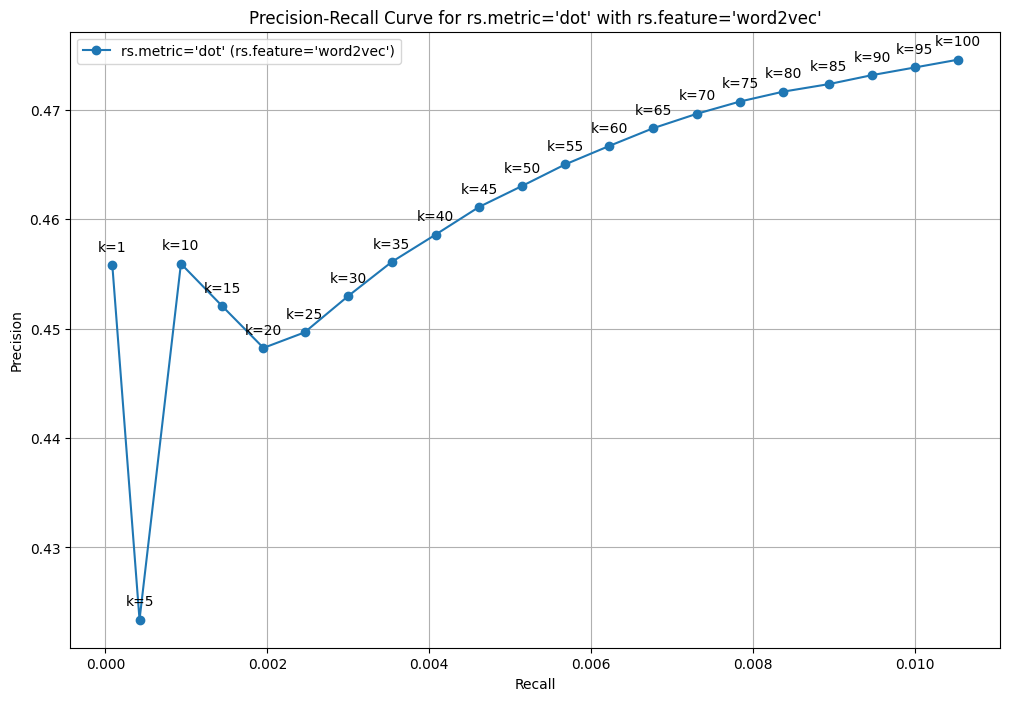

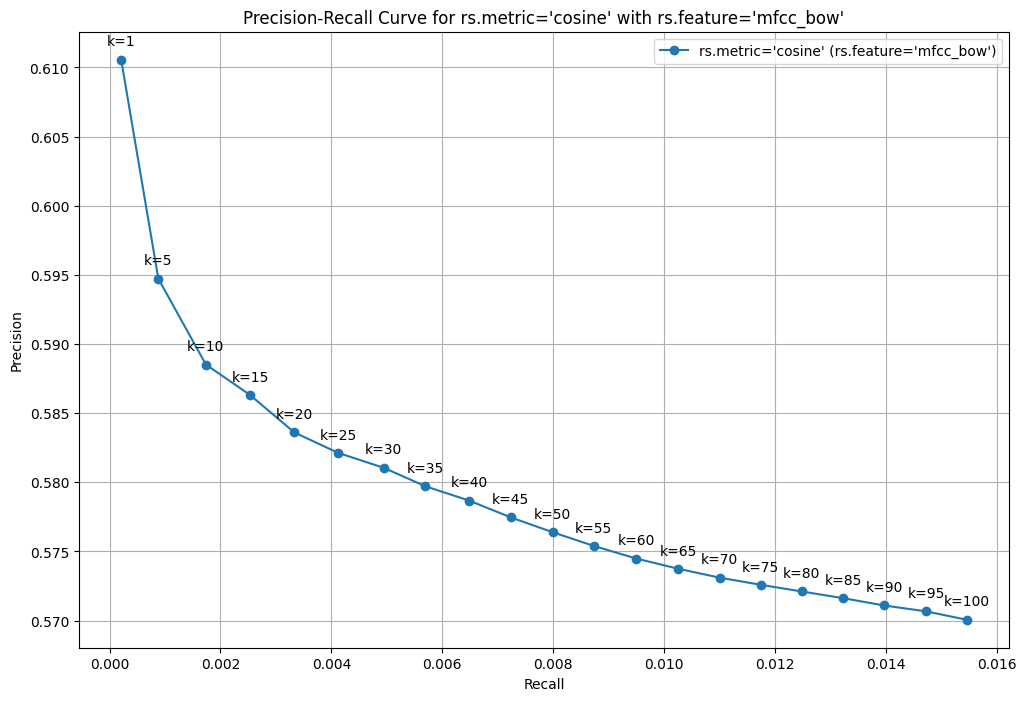

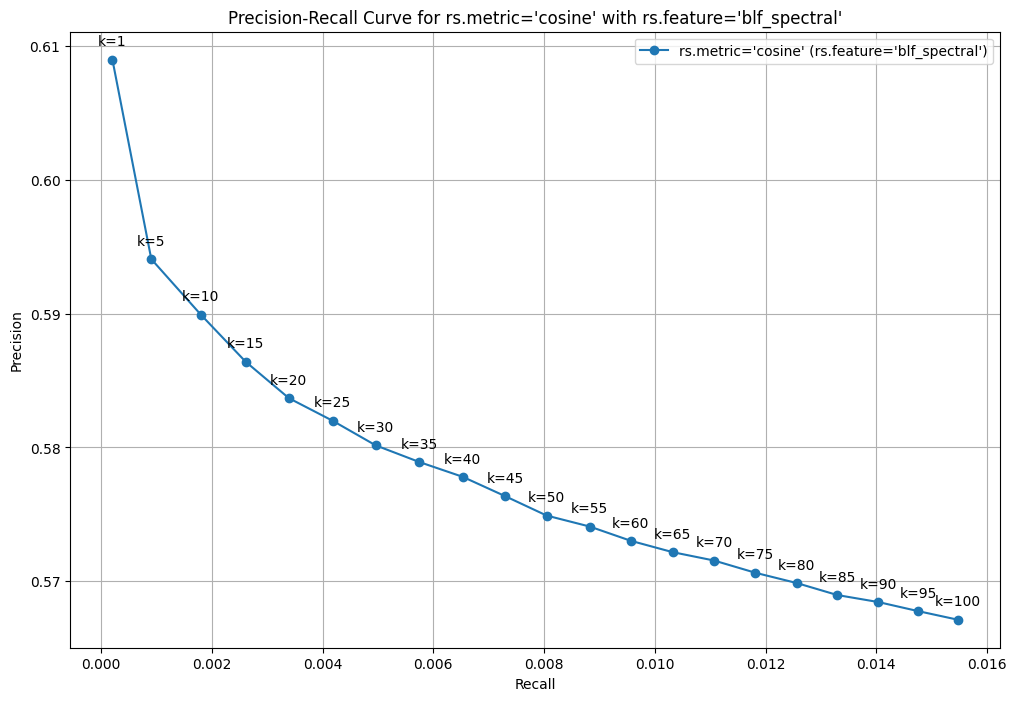

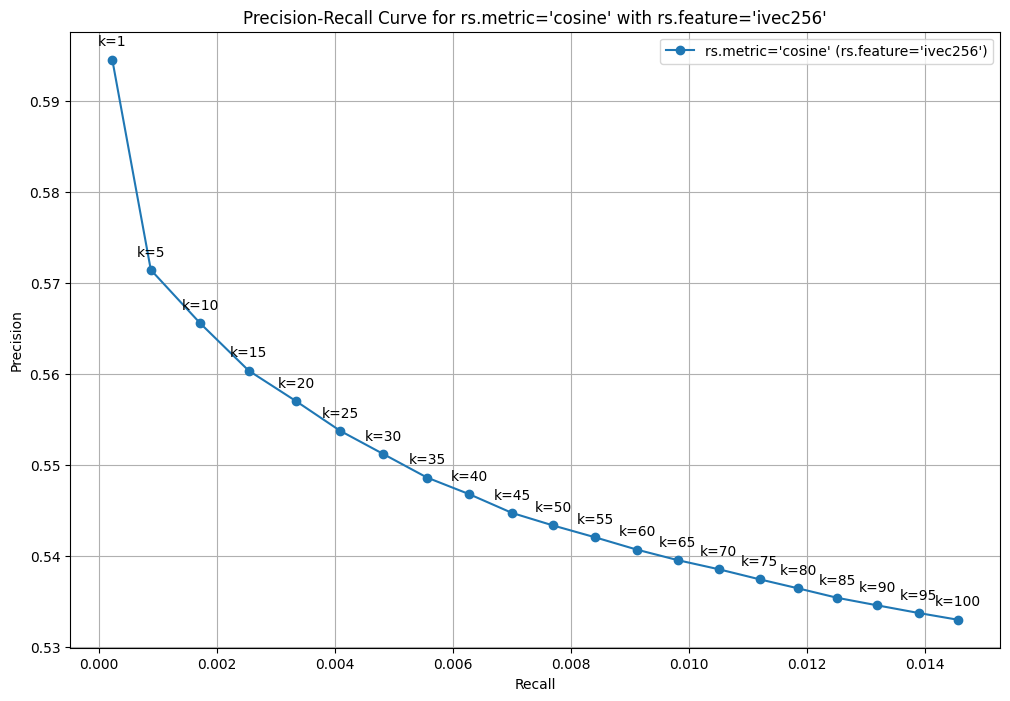

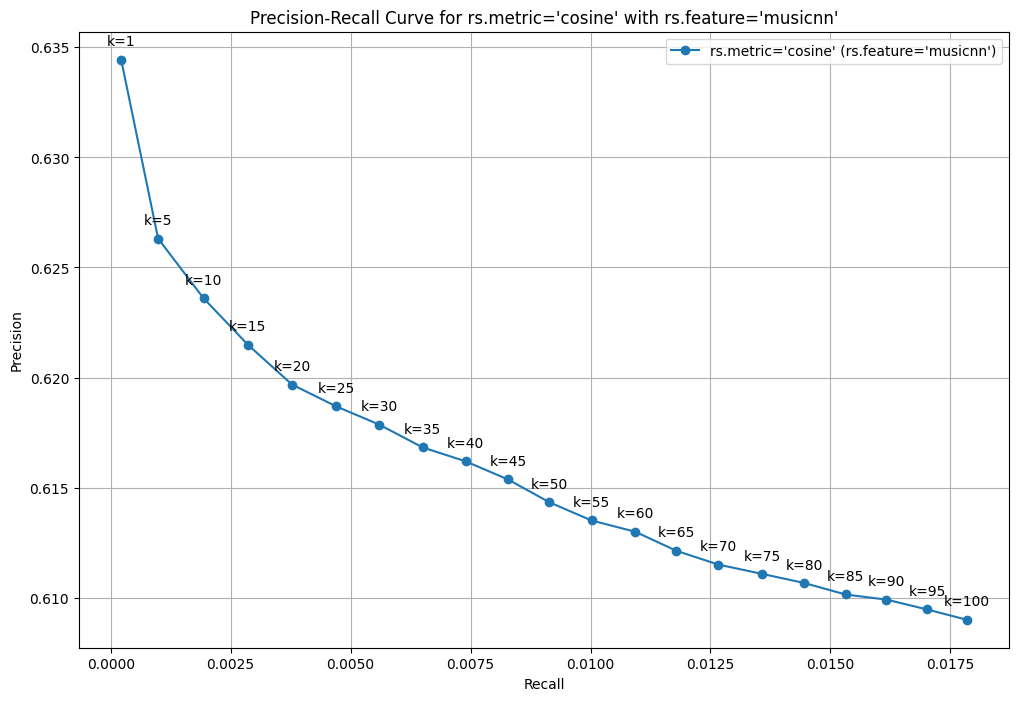

In [9]:
for rs in evaluation.itertuples():
    metrics_df = rs.precision_and_recall_interval

    plt.figure(figsize=(12, 8))
    plt.plot(metrics_df['recall'], metrics_df['precision'], marker='o', label=f"{rs.metric=} ({rs.feature=})")

    # Annotate each point with its k value
    for k, recall, precision in zip(metrics_df.index, metrics_df['recall'], metrics_df['precision']):
        plt.annotate(f"k={k}", (recall, precision), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(f'Precision-Recall Curve for {rs.metric=} with {rs.feature=}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()